In [1]:
import sys
sys.path.append('../')
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2
import random
import numpy as np
from pathlib import Path
from PIL import Image
from utils import *

import os
import cv2
import glob
import numpy as np
import multiprocessing as mp
from pathlib import Path

%matplotlib inline

### convert all images in a folder to npy format

In [3]:
images = glob.glob('../data/aug_6/*')
npy_folder = '../data/npy_files/aug_6'
mkdir(npy_folder)

In [9]:
def conv2npy(path):
    '''take jpeg/png convert them to resized npy image with same aspect ratio'''
    image = Image.open(path)
    w, h = image.size # pil returns w, h
#     image = image.resize((256, int(h/w * 256))) # w, h
#     w, h = image.size
    if h > w:
        r = w/h
        image = image.resize((int(w/h * 256), 256)) # w, h
#         print(path)
        filename = Path(path).stem
        np.save(os.path.join('../data/npy_files/aug_6', filename + '.npy'), np.array(image))
    
# pil image.size returns w, h, np.array/ cv2 return h, w

In [7]:
for path in images:
    conv2npy(path)

../data/aug_6/42394_right.jpeg
../data/aug_6/41535_right.jpeg
../data/aug_6/8215_right.jpeg
../data/aug_6/22462_left.jpeg
../data/aug_6/188219f2d9c6.png
../data/aug_6/3206_right.jpeg
../data/aug_6/37586_right.jpeg
../data/aug_6/28355_right.jpeg
../data/aug_6/24559_right.jpeg
../data/aug_6/23380_right.jpeg
../data/aug_6/32711_left.jpeg
../data/aug_6/20032_left.jpeg
../data/aug_6/18254_right.jpeg
../data/aug_6/748_right.jpeg
../data/aug_6/15665_left.jpeg
../data/aug_6/769_right.jpeg
../data/aug_6/748_left.jpeg


KeyboardInterrupt: 

In [10]:
pool = mp.Pool(mp.cpu_count())
pool.map(conv2npy, images)
pool.close()

In [11]:
from albumentations import PadIfNeeded
aug = PadIfNeeded(256, 256, p=1)

In [ ]:
image.size, np.array(image).shape

../data/npy_files/aug_6/000c1434d8d7.npy (201, 256, 3)


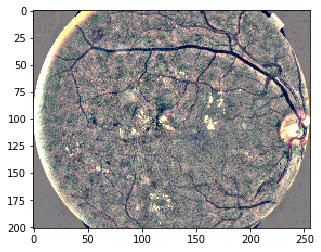

In [15]:
path = '../data/npy_files/aug_6/000c1434d8d7.npy'
img = np.load(path)
plt.imshow(img)
print(path, img.shape)
# plt.imshow(np.array(Image.open(path)))

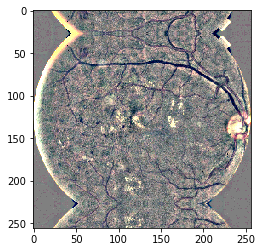

In [16]:
image = aug(image=img)['image']
plt.imshow(image)

In [ ]:
# read all three data labels files
train1 = pd.read_csv('../data/train.csv')
train2 = pd.read_csv('../data/2015.csv')
train3 = pd.read_csv('../data/train_messidor.csv')
train4 = pd.read_csv('../external_data/IDRiD/idrid.csv')
train5 = pd.read_csv('../external_data/messidor-2/messidor_data.csv')
test = pd.read_csv('../data/sample_submission.csv')

In [ ]:
train3['diagnosis'].value_counts()


In [ ]:
train5.head()

In [ ]:
train5['ext'] = train5['image_id'].apply(lambda x: x.split('.')[-1])

In [ ]:
gb = train5.groupby('ext')
train5.shape

In [ ]:
png = gb.get_group('png')
png.shape, train3.shape

In [ ]:
jpg = gb.get_group('jpg')
jpg.shape

In [ ]:
jpg.head()

In [ ]:
path = '../external_data/messidor-2/' + jpg.iloc[0]['image_id']
img = cv2.imread(path)
plt.imshow(img)

In [ ]:
train4['diagnosis'].value_counts(), train4.shape, 

In [ ]:
for i in range(1000):
    path = '../data/all_images/' + train2.iloc[i]['id_code']
    img = cv2.imread(path)
    print(img.shape)

In [ ]:
plt.imshow(img)

In [ ]:
# train5.apply(lambda x: print(f'mv test/{x[0]}.jpg test/test{x[0]}.jpg'), axis=1);

In [ ]:
# concatenate into one
train1['path'] = train1['id_code'].apply(lambda x: "../data/all_images/" + x)
#test['path'] = test['id_code'].apply(lambda x: "../data/test_images/" + x)
train2['path'] = train2['id_code'].apply(lambda x: "../data/all_images/" + x)
train3['path'] = train3['id_code'].apply(lambda x: "../data/all_images/" + x)
train_df = pd.concat([train1, train2, train3], axis=0)

In [ ]:
train_df.head()

In [ ]:
def load_rgb(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    return image

def load_ben_color(path, size, sigmaX=10, crop=False):
    """if crop=True: center crop retina"""
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if crop:
        image = crop_image_from_gray(image)
    image = cv2.resize(image, (size, size))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(
        image, (0, 0), sigmaX), -4, 128)
    return image


def load_ben_color_cropped(path, IMG_SIZE, sigmaX=10, tol=8):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image, tol=tol)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    return image

def load_ben_gray(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.addWeighted(
       image, 4, cv2.GaussianBlur(image, (0, 0), IMG_SIZE / 10), -4, 128
    )  # Ben Graham's preprocessing method [1]
    ## (IMG_SIZE, IMG_SIZE) -> (IMG_SIZE, IMG_SIZE, 3)
    image = image.reshape(IMG_SIZE, IMG_SIZE, 1)
    image = np.repeat(image, 3, axis=-1)
    return image

def crop_image_from_gray(img,tol=7):
#     pdb.set_trace()
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [ ]:
names = train_df.id_code.values
#names = test.id_code.values
save_folder = '../data/npy_files/'
IMG_SIZE = 456
mkdir(save_folder)

In [ ]:
train_df.shape

In [ ]:
test.head()

In [ ]:
# this thing is slow at start (the png and tif images) then speeds up after ~5k iterations (the jpegs)
for idx, row in tqdm(test.iterrows()):
    image = load_ben_color_cropped(row.path, IMG_SIZE, tol=10)
    np.save(os.path.join(save_folder, row.id_code + '.npy'), image)

In [ ]:
fname = test.iloc[0]['id_code']
fname

### Analysis

In [ ]:
image = np.load(f'../data/npy_files/bgcc456/{fname}.npy')
plt.imshow(image)

In [ ]:
npy_files = glob('../data/train_images/npy_bengrahm_color/*.npy')
npy = np.random.choice(npy_files)
print(npy)
image = np.load(npy)
plt.imshow(image); 

In [ ]:
# idx=0
idx+=1
#print(idx)
#fname = names[idx]
fname = "20060523_50153_0100_PP"
image_folder = '../external_data/messidor/train_images/'
img_path = os.path.join(images_folder, fname + ".tif")
image_org = load_ben_color(img_path)
image_cropped = load_ben_color_cropped(img_path, tol=10)
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(image_org, cmap="gray")
label = ''
#label = str(train_df.iloc[idx]['diagnosis'])
plt.title('label: ' + label)
plt.subplot(1, 2, 2)
plt.imshow(image_cropped, cmap="gray")
plt.title('label: ' + label) 
plt.show();

In [ ]:
image = cv2.imread(img_path)
image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
mask = gray_img> 8 


In [ ]:
plt.imshow(mask)

In [ ]:
check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
if (check_shape == 0): # image is too dark so that we crop out everything,
    return img # return original image
else:
    img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
    img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
    img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
#         print(img1.shape,img2.shape,img3.shape)
    img = np.stack([img1,img2,img3],axis=-1)

###  save all npy files in one npy file

In [ ]:
images = []  # because small dataset.
train1 = pd.read_csv('../data/test.csv')
fnames = train1.id_code.tolist()
for fname in tqdm(fnames):
    path = os.path.join('../data/test_images/', fname + '.png')
    image = load_ben_color(path, size=456, crop=True)
#     path = os.path.join('../data/npy_files/bgcc456/' + fname + '.npy')
#     image = np.load(path)
    images.append(image)

In [ ]:
np.save('../data/npy_files/all_test_bgcc456.npy', images)

#### messidor xls to csv

In [ ]:
# combining messidors label xls files into a csv file
import pandas as pd
from glob import glob
# filenames
excel_names = glob('../external_data/messidor/*.xls')

# read them in
excels = [pd.ExcelFile(name) for name in excel_names]

# turn them into dataframes
frames = [x.parse(x.sheet_names[0], header=None,index_col=None) for x in excels]

# delete the first row for all frames except the first
# i.e. remove the header row -- assumes it's the first
frames[1:] = [df[1:] for df in frames[1:]]

# concatenate them..
combined = pd.concat(frames)

# write it out
#combined.to_excel("c.xlsx", header=False, index=False)

In [ ]:
combined.head()

In [ ]:
combined.shape

In [ ]:
combined.to_csv('../external_data/messidor/train.csv', header=None, index=False)

In [ ]:
combined['id_code'] = combined['Image name'].apply(lambda x: x.split('.')[0])
combined['diagnosis'] = combined['Retinopathy grade']
combined = combined.drop(columns=['Image name', 'Ophthalmologic department', 'Retinopathy grade', 'Risk of macular edema '], axis=0)
combined.to_csv('../external_data/messidor/combinedsidor.csv')

### Test images sizes of the data prepared so far

In [ ]:
# !ls ../data/train_images/

In [ ]:
img = np.load('../data/train_images/npy_bengrahm_color/000c1434d8d7.npy')
plt.imshow(img)
img.shape

In [ ]:
img = np.load('../data/train_images/bgcc300/000c1434d8d7.npy')
plt.imshow(img)
img.shape

### copy files to class wise directories

In [ ]:
train1.shape

In [ ]:
train1.apply(lambda x: print(f'cp all_images/{x[0]} class_wise/class_{x[1]}'), axis=1); # expand this, copy with keyboard ctrl+shift whatever, paste in a bash file, run it

### save preprocessed images

In [ ]:
# libraries

# functions

def crop_image_from_gray(img, tol=7):
    """
    Crop out black borders
    https://www.kaggle.com/ratthachat/aptos-updated-preprocessing-ben-s-cropping
    """

    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mask = gray_img > tol
        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if (check_shape == 0):
            return img
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img

def scaleRadius(img,scale):
    """
    Part of Ben's technique
    https://github.com/btgraham/SparseConvNet/blob/kaggle_Diabetic_Retinopathy_competition/competitionreport.pdf
    """
    x=img[int(img.shape[0]/2),:,:].sum(1)
    r=(x>x.mean()/10).sum()/2
    s=scale*1.0/r
    return cv2.resize(img, (0,0), fx=s,fy=s)

def aug_0(img_path):
    """
    Crop black area
    """

    img = cv2.imread(img_path)
    img = crop_image_from_gray(img)
    cv2.imwrite(
        '/media/ains/dec4dfd1-4e1b-4f58-8203-1e4a2fb67acf/preprocessing_experiment/aug_0/{}'.format(
            os.path.basename(img_path)), img)


def aug_1(img_path):
    """
    Ben's technique
    https://github.com/btgraham/SparseConvNet/blob/kaggle_Diabetic_Retinopathy_competition/competitionreport.pdf
    """

    scale = 300

    a = cv2.imread(img_path)
    a = scaleRadius(a, scale)
    a = cv2.addWeighted(a, 4, cv2.GaussianBlur(a, (0, 0), scale/30), -4, 128)
    b = np.zeros(a.shape)
    cv2.circle(b,(int(a.shape[1]/2), int(a.shape[0]/2)), int(scale*0.9),(1,1,1),-1,8,0)
    a = a*b-128*(1-b)

    cv2.imwrite(
        '/media/ains/dec4dfd1-4e1b-4f58-8203-1e4a2fb67acf/preprocessing_experiment/aug_1/{}'.format(
            os.path.basename(img_path)), a)


def aug_2(img_path):
    """
    Ben's technique with median blur
    https://github.com/btgraham/SparseConvNet/blob/kaggle_Diabetic_Retinopathy_competition/competitionreport.pdf
    """

    scale = 300

    a = cv2.imread(img_path)
    a = scaleRadius(a, scale)

    k = np.min(a.shape[0:2]) // 20 * 2 + 1

    a = cv2.addWeighted(a, 4, cv2.medianBlur(a, k), -4, 128)
    b = np.zeros(a.shape)
    cv2.circle(b,(int(a.shape[1]/2), int(a.shape[0]/2)), int(scale*0.9),(1,1,1),-1,8,0)
    a = a*b-128*(1-b)

    cv2.imwrite(
        '/media/ains/dec4dfd1-4e1b-4f58-8203-1e4a2fb67acf/preprocessing_experiment/aug_2/{}'.format(
            os.path.basename(img_path)), a)


def aug_3(img_path):
    """
    Cropping, apply CLAHE and then stack the green channel
    """

    image = cv2.imread(img_path)
    image = crop_image_from_gray(image)
    image = image[:, :, 1]

    image = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(image)
    image = np.dstack((image, image, image))

    cv2.imwrite(
        '../data/aug_3/{}'.format(
            os.path.basename(img_path)), image)


def aug_4(img_path):
    """
    Cropping, apply CLAHE, median blur and then stack the green channel
    """

    image = cv2.imread(img_path)
    image = crop_image_from_gray(image)

    image = image[:, :, 1]
    image = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(image)
    image = np.dstack((image, image, image))

    k = np.min(image.shape[0:2]) // 20 * 2 + 1
    bg = cv2.medianBlur(image, k)
    image = cv2.addWeighted(image, 4, bg, -4, 128)

    cv2.imwrite(
        '/media/ags/DATA/CODE/kaggle/aptos2019-blindness-detection/data/aug_4/{}'.format(
            os.path.basename(img_path)), image)



def aug_5(img_path):
    """
    Cropping, apply CLAHE to all channels
    """

    image = cv2.imread(img_path)
    image = crop_image_from_gray(image)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    lab[..., 0] = clahe.apply(lab[..., 0])
    image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    cv2.imwrite(
        '/media/ains/dec4dfd1-4e1b-4f58-8203-1e4a2fb67acf/preprocessing_experiment/aug_5/{}'.format(
            os.path.basename(img_path)), image)


def aug_6(img_path):
    """
    Cropping, apply CLAHE to all channels with median blur
    """

    image = cv2.imread(img_path)
    image = crop_image_from_gray(image)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    lab[..., 0] = clahe.apply(lab[..., 0])
    image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    k = np.min(image.shape[0:2]) // 25 * 2 + 1
    bg = cv2.medianBlur(image, k)
    image = cv2.addWeighted(image, 4, bg, -4, 128)

    cv2.imwrite(
        '/media/ags/DATA/CODE/kaggle/aptos2019-blindness-detection/data/aug_6/{}'.format(
            os.path.basename(img_path)), image)


def aug_7(img_path):
    """
    Cropping, dissect into 4, apply CLAHE, median blur and then stack the green channel
    Based on https://www.sciencedirect.com/science/article/pii/S2212017313005781
    """

    image = cv2.imread(img_path)
    image = crop_image_from_gray(image)

    height, width, depth = image.shape

    image = image[:, :, 1]

    q1 = image[0:int(height / 2), 0:int(width / 2)]
    q2 = image[0:int(height / 2), int(width / 2):]
    q3 = image[int(height / 2):, 0:int(width / 2)]
    q4 = image[int(height / 2):, int(width / 2):]

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    q1 = clahe.apply(q1)
    k = np.min(q1.shape[0:2]) // 20 * 2 + 1
    bg = cv2.medianBlur(q1, k)
    q1 = cv2.addWeighted(q1, 4, bg, -4, 128)

    q2 = clahe.apply(q2)
    k = np.min(q2.shape[0:2]) // 20 * 2 + 1
    bg = cv2.medianBlur(q2, k)
    q2 = cv2.addWeighted(q2, 4, bg, -4, 128)

    q3 = clahe.apply(q3)
    k = np.min(q3.shape[0:2]) // 20 * 2 + 1
    bg = cv2.medianBlur(q3, k)
    q3 = cv2.addWeighted(q3, 4, bg, -4, 128)

    q4 = clahe.apply(q4)
    k = np.min(q4.shape[0:2]) // 20 * 2 + 1
    bg = cv2.medianBlur(q4, k)
    q4 = cv2.addWeighted(q4, 4, bg, -4, 128)

    h1 = np.concatenate((q1, q2), axis=1)
    h2 = np.concatenate((q3, q4), axis=1)
    image = np.concatenate((h1, h2), axis=0)

    image = np.dstack((image, image, image))

    cv2.imwrite(
        '/media/ains/dec4dfd1-4e1b-4f58-8203-1e4a2fb67acf/preprocessing_experiment/aug_7/{}'.format(
            os.path.basename(img_path)), image)



def aug_8(img_path):
    """
    Cropping, dissect into 4, apply CLAHE, median blur across all channels
    Based on https://www.sciencedirect.com/science/article/pii/S2212017313005781
    """

    image = cv2.imread(img_path)
    image = crop_image_from_gray(image)

    height, width, depth = image.shape

    q1 = image[0:int(height / 2), 0:int(width / 2)]
    q2 = image[0:int(height / 2), int(width / 2):]
    q3 = image[int(height / 2):, 0:int(width / 2)]
    q4 = image[int(height / 2):, int(width / 2):]

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    q1 = cv2.cvtColor(q1, cv2.COLOR_BGR2LAB)
    q1[..., 0] = clahe.apply(q1[..., 0])
    q1 = cv2.cvtColor(q1, cv2.COLOR_LAB2BGR)
    k = np.min(q1.shape[0:2]) // 20 * 2 + 1
    bg = cv2.medianBlur(q1, k)
    q1 = cv2.addWeighted(q1, 4, bg, -4, 128)

    q2 = cv2.cvtColor(q2, cv2.COLOR_BGR2LAB)
    q2[..., 0] = clahe.apply(q2[..., 0])
    q2 = cv2.cvtColor(q2, cv2.COLOR_LAB2BGR)
    k = np.min(q2.shape[0:2]) // 20 * 2 + 1
    bg = cv2.medianBlur(q2, k)
    q2 = cv2.addWeighted(q2, 4, bg, -4, 128)

    q3 = cv2.cvtColor(q3, cv2.COLOR_BGR2LAB)
    q3[..., 0] = clahe.apply(q3[..., 0])
    q3 = cv2.cvtColor(q3, cv2.COLOR_LAB2BGR)
    k = np.min(q3.shape[0:2]) // 20 * 2 + 1
    bg = cv2.medianBlur(q3, k)
    q3 = cv2.addWeighted(q3, 4, bg, -4, 128)

    q4 = cv2.cvtColor(q4, cv2.COLOR_BGR2LAB)
    q4[..., 0] = clahe.apply(q4[..., 0])
    q4 = cv2.cvtColor(q4, cv2.COLOR_LAB2BGR)
    k = np.min(q4.shape[0:2]) // 20 * 2 + 1
    bg = cv2.medianBlur(q4, k)
    q4 = cv2.addWeighted(q4, 4, bg, -4, 128)

    h1 = np.concatenate((q1, q2), axis=1)
    h2 = np.concatenate((q3, q4), axis=1)
    image = np.concatenate((h1, h2), axis=0)

    cv2.imwrite(
        '/media/ains/dec4dfd1-4e1b-4f58-8203-1e4a2fb67acf/preprocessing_experiment/aug_8/{}'.format(
            os.path.basename(img_path)), image)


def aug_9(img_path):
    """
    Cropping, apply CLAHE to all channels without converting to LAB
    """

    image = cv2.imread(img_path)
    image = crop_image_from_gray(image)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    image[..., 0] = clahe.apply(image[..., 0])
    image[..., 1] = clahe.apply(image[..., 1])
    image[..., 2] = clahe.apply(image[..., 2])

    cv2.imwrite(
        '/media/ains/dec4dfd1-4e1b-4f58-8203-1e4a2fb67acf/preprocessing_experiment/aug_9/{}'.format(
            os.path.basename(img_path)), image)

def aug_10(img_path):
    """
    Cropping, apply CLAHE to all channels without converting to LAB, then apply median
    """

    image = cv2.imread(img_path)
    image = crop_image_from_gray(image)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    image[..., 0] = clahe.apply(image[..., 0])
    image[..., 1] = clahe.apply(image[..., 1])
    image[..., 2] = clahe.apply(image[..., 2])

    k = np.min(image.shape[0:2]) // 20 * 2 + 1
    bg = cv2.medianBlur(image, k)
    image = cv2.addWeighted(image, 4, bg, -4, 128)

    cv2.imwrite(
        '/media/ains/dec4dfd1-4e1b-4f58-8203-1e4a2fb67acf/preprocessing_experiment/aug_10/{}'.format(
            os.path.basename(img_path)), image)


In [ ]:

def resampled(df, count_dict):
    ''' resample from df with replace=False'''
    def sample(obj):  # [5]
        return obj.sample(n=count_dict[obj.name], replace=False, random_state=69)
    sampled_df = df.groupby('diagnosis').apply(sample).reset_index(drop=True)
    return sampled_df



In [ ]:
from collections import defaultdict
train1 = pd.read_csv('../data/train.csv')
train2 = pd.read_csv('../data/2015.csv')
train3 = pd.read_csv('../data/train_messidor.csv')
train4 = pd.read_csv('../data/idrid.csv')
#count_dict = defaultdict(lambda: 1900)
count_dict = {
    0: 2000,
    2: 2000,
    1: 2000,
    3: 2000,
    4: 1914,
}
# df = resampled(train2, count_dict)
# df = train2.append(resampled(train2, count_dict), ignore_index=True)
# df = train3.append(train4, ignore_index=True)
# df = df.append(train3, ignore_index=True)
df = pd.read_csv('../data/sample_submission.csv')

In [ ]:
df['diagnosis'].value_counts()

In [ ]:
df['path'] = df.apply(lambda x: '../data/test_images/' + x[0] + '.png', axis=1)
# df['path'] = df.apply(lambda x: '../data/all_images/' + x[0], axis=1)
images = df['path'].tolist()

In [ ]:
df.head()

In [ ]:
# use multiprocessing to create the images.
pool = mp.Pool(mp.cpu_count())
pool.map(aug_6, images)
pool.close()

###  modify labels in train.csv

In [ ]:
ids = '''
2221cf5c7935.png, 0, 2
2d07162a13b1.png, 0, 1
4f0866b90c27.png, 3, 4
772af553b8b7.png, 3, 4
bf8092e4001d.png, 3, 4
fcc6aa6755e6.png, 3, 4
4f0866b90c27.png, 3, 4
5b3e7197ac1c.png, 3, 4
'''
for id_ in ids.strip().split('\n'):
    id_  = id_.split(',')
    name = id_[0]
    new_label = int(id_[2])
    idx = train1.query('id_code == "%s"' % name).index
    print(train1.iloc[idx]['diagnosis'], new_label)
#     train1.at[idx, 'diagnosis'] = new_label
    

In [ ]:
# train1.to_csv('../data/train.csv', index=False)
# original train.csv is already saved as train_org.csv